In [1]:
# imports
from tqdm import tnrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
%matplotlib inline  

# alphabet
import string

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
def get_accuracy(logit, target):
    batch_size = len(target)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+nhidden*(noutputs+1)

# define the nnumber of parameters we need
def nparam_MLP(N_INPUTS,N_HIDDEN,N_OUTPUTS):
    input_to_hidden1 = (N_INPUTS+1)*N_HIDDEN #+1 for bias
    hidden1_to_hidden2 = (N_HIDDEN + 1)*N_HIDDEN
    hidden2_to_output = (N_OUTPUTS)*(N_HIDDEN+1)
    return(sum([input_to_hidden1,hidden1_to_hidden2,hidden2_to_output]))


In [3]:
# a prototype MLP
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_neurons, n_output,  device):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs # set the number of neurons in the input layer
        self.n_hidden_neurons = n_hidden_neurons # how many neurons are in each hidden layer
        self.n_output = n_output # set the number of neurons in the output layer
        self.sig = nn.Sigmoid() # set the activation function 
        self.tanh = nn.Tanh()
        self.n_hidden = n_hidden_neurons
        self.encoder = nn.Linear(n_inputs, n_hidden_neurons) # encode input
        self.recurrent = nn.Linear(n_hidden_neurons,n_hidden_neurons) # recurrent connections
        self.decoder = nn.Linear(n_hidden_neurons, n_output) # decode output
                
    def forward(self, x):
        self.hidden1 = self.tanh(self.encoder(x))
        self.hidden2 = self.tanh(self.recurrent(self.hidden1))
        self.output = self.decoder(self.hidden2)
        return self.output
    

In [4]:
# Test MLP on Anna Karenina
# Load Anna Karenina
from torch.utils.data import DataLoader # dataloader 
import sys
sys.path.insert(0,'../final_project/Data/')
from AnnaDataset_MLP import AnnaDataset, InvertAnna # import AK dataset
import torchvision
import torchvision.transforms as transforms

# params
BATCH_SIZE = 500 # how many batches we are running
N_STEPS = 10 # How many characters are we inputting into the list at a time
N_HIDDEN_NEURONS = 512 # how many neurons per hidden layer
N_INPUTS = 77*N_STEPS
N_OUTPUTS = 77
N_LAYERS = 2 # 2 hidden layers
N_EPOCHS = 11 # how many training epocs
learning_rates = np.asarray([2]) # learning rates
N_REPS = 1 # len(learning_rates) # the number of learning repetitions
N_PARAMS = nparam_MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS)
gidx = int(N_HIDDEN_NEURONS/2)

# regularization parameters
lambdas = [0]#np.arange(0,1e-2,3e-3,dtype=np.float)
N_LAMBDA = len(lambdas)

# load data
# list all transformations
transform = transforms.Compose(
    [transforms.Normalize((0,), (0.3,))])

dataset = AnnaDataset(N_STEPS) # load the dataset
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries
testloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries

In [5]:
# regularizing digonal blocks of the partitioned RNN
# initialize arrays of loss values and weights over the number of epohcs, the number of lambdas we are testing, and the number of reps. 
train_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS)) 
train_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
test_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
test_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
Phist_P = np.zeros((N_PARAMS,N_EPOCHS,N_LAMBDA,N_REPS))

model_P = [None]*N_LAMBDA*N_REPS # array of models
regval_P = [] # array of regularization values
for r in tnrange(N_REPS): # loop over the number of reps
    for k in tnrange(N_LAMBDA): # loop over the number of different lambda values
        reg_lambda = lambdas[k] # set the regularization lambda
        model_path = './model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10)) # path to which we will save the model
        model_P[k+r*N_LAMBDA] = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device).to(device) # create the model
        l2_reg = torch.tensor(1,device=device) # create the l2 regularization value tensor
        optimizer = torch.optim.SGD(model_P[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9) # set the function for SGD
        criterion = nn.CrossEntropyLoss() # set the loss function
        
        # note that cross-entropy loss expects the indices of the class, not the one-hot. So, for A = [1,0,0,...] and B = [0,1,0,...], A is 0 and B is 1
        
        for epoch in range(N_EPOCHS): # for each training epoch
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_P[k+r*N_LAMBDA].train() 
            for p, param in enumerate(model_P[k+r*N_LAMBDA].parameters()): # go through all the model parameters
                if param.requires_grad:
                    plist = torch.flatten(param.data) # set the list of parameters
                    for j in range(plist.size(0)):
                        while nps < Phist_P.shape[0]:
                            Phist_P[nps,epoch,k,r]=plist[j].item() # update the parameters
                            nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device) # x is the training set, y_tar is the output label
                x = x-0.3
                optimizer.zero_grad() # set gradients to 0
                y_pred = model_P[k+r*N_LAMBDA](x.view(x.shape[0],x.shape[1]*x.shape[2])) # compute the prediction. 
                loss = criterion(y_pred,y_tar) 
                for p,param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN_NEURONS and param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=1) # update the l2 regularization constant
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=1)
                        elif param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_P.append(l2_reg.item()) # add the l2 regularization to  the running list
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE # compute the loss
                loss.backward() # backpropogate the loss
                optimizer.step() # run SGD
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred, y_tar) # compute accuracy
            
            running_test_acc=0
            running_test_loss=0
            model_P[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                x_test = x_test - 0.3
                y_test_pred = model_P[k+r*N_LAMBDA](x_test.view(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
                loss = criterion(y_test_pred,y_test_tar)
                
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred, y_test_tar)
                
            train_loss_P[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_P[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_P[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_P[epoch,k,r] = running_test_acc/len(testloader)
            print(train_acc_P[epoch,k,r])
            
        # save the model and free the memory  
        torch.save(model_P[k+r*N_LAMBDA].state_dict(), model_path)
        model_P[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

31.7720194026
38.1439877457
41.2838907327
44.0883329078
46.4393668624
48.4286443707
50.0045953536
51.3178452898
52.4393668624
53.3819249426
54.2236405412



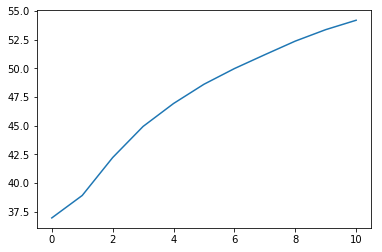

In [12]:
#plt.imshow(x[0,:,:])
#plt.plot(y_pred.detach().numpy()[0,:])
#torch.max(y_pred,1)
plt.plot(np.mean(test_acc_P,1))

In [7]:
def readtxt(txt_name = 'anna.txt'):
    dir_path = os.path.dirname(os.path.realpath(__file__))
    txt_file = os.path.join(dir_path,txt_name)
    # load the whole book
    file = open(self.txt_file)
    alltxt = file.read()
    # remove newline formmating
    alltxt = alltxt.replace("\n\n", "&").replace("\n", " ").replace("&", "\n")
    # define categories
    categories = list(sorted(set(alltxt)))
    # integer encode
    label_encoder = LabelEncoder()
    label_encoder.fit(categories)
    integer_encoded = torch.LongTensor(label_encoder.transform(list(alltxt)))
    return integer_encoded, categories

# def onehotencode(integer_encoded_batch,n_cat):
    
def get_next_batch(dat,batch_size):
    x_int = 
    y_int = 
    x_hot = onehotencode(x_int): 
    return x_hot, y_int 
    
    

SyntaxError: invalid syntax (<ipython-input-7-4c48a8559e7c>, line 1)